# Data Anaysis Project part1:

I am using Vancouver rental ads on craigslist to analyze rental market. Later, I will create the class to be able to analyze dynamically. Also, I will start collecting the data and save them to the CSV, so I can analyze the trend of the rental market as well. 

I will follow what I am learning from Google Data Analytics course to complete this project.

* Ask
* Prepare
* Process
* Analyze
* Share
* Act



## Overview of the project:

Analyze housing rental market in Fraser Valley to find out what is hot to real estate investors in this area. Iam going to create the code to analyze dynamically so the investors can apply in their area for their own use.  


## ASK 
    
    Find out what is 'HOT' in the market for investor, so I can find a property for them. Find out supply and demand of the rental housing market and calculate appropreate purchase price. 

#### What are the questions to ask?
Supply side:
* How much is the market rental price?
* What type of the rental is most popular and least popular?
* How many ads per day? Number of supply 
* Is rental price rising or decreasing over time?
* What is the correlation between housing price and rental price?
* From those questions, what is my prediction of the rental market? 

Demand side:
* What kind of propety does people look for rent?
* What is the price range they are looking for?
* What are the purposes of renting. (Who is looking for rent)


#### Review Google Data Analysis course and create checklist:
* Ask effective questions
* Define the problems
* Using structured thinking
* Communicate with others



## Prepare  

#### Using Craigslist add to collect market data: (Supply side)
Scrape craigslist rental housing pages and store in csv file. 

<a href='https://github.com/rileypredum/East-Bay-Housing-Web-Scrape/blob/master/EB_Apt_Prices_Final.ipynb'>Code: I will use this code and modify for my situation.  </a> <br>
<a href='https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981'>Explaning</a>


#### Review from Google Data Analysis course:
* Understand how data is generated and collect. 
    * The data is collected from Craigslist ads. 
* Identify and use different data formats, types, and structures. 
* Make sure data is unbiased and credible. 
    * The data is live advertisement, so it is great to see today's market price. However, craigslist doesn't seems today's most favorite site to advertize so it might not accurately show the reality. 
* Organize and protect data. 

In [1]:
# Import libralis
from requests import get
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import numpy as np

from time import sleep
import re
from random import randint
from warnings import warn
from time import time
from IPython.display import clear_output

In [2]:
class Url:
    def __init__(self, city_name, sub_city=None, num_post=0):
        self.city_name = city_name
        self.sub_city = sub_city
        self.num_post = num_post
        self.url = self.get_url()
        
    def get_url(self):
        if self.city_name == 'Abbotsford':
            url = f'https://{self.city_name.lower()}.craigslist.org/search/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        else:
            url = f'https://{self.city_name.lower()}.craigslist.org/search/{self.sub_city}/apa?s={self.num_post}sort=date&bundleDuplicates=1&min_price=&max_price=&availabilityMode=0&sale_date=all+dates'
        return url 

In [3]:
# Vanvouver rental housing
url = Url("Vancouver", 'van')
url_ = url.url

response = get(url_)


soup = BeautifulSoup(response.text, 'html.parser')

posts = soup.find_all('li', class_='result-row')
print(type(posts)) # to double check that I got resultSet
print(len(posts)) # to double check I got 120 elements

<class 'bs4.element.ResultSet'>
123


In [4]:
%%time
# Find the total number of posts to find the limit of the pagination
city = 'Vancouver'
sub_city = 'van'
response = get(url_)
soup = BeautifulSoup(response.text, 'html.parser')
posts = soup.find_all('li', class_='result-row')
results_num = soup.find('div', class_='search-legend')
results_total = int(results_num.find('span', class_='totalcount').text)
print(f"Total number of search result: {results_total}")

# each page has 119 posts so each new page is defined as follows; s=120, s=240, .....
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_date = []
post_cities = []
num_bedroom = []
sqfts = []
prices = []
post_titles = []
post_links = []

for page in pages:
    
    # get request
    url = Url(city_name=city, sub_city=sub_city, num_post=page)
    url_ = url.url
    response = get(url_)
    
    sleep(1)
    
    # throw warning for status code that are not 200
    if response.status_code != 200:
        warn(f'Request: {requests}; Status code: {response.status_code}')
        
    soup = BeautifulSoup(response.text, 'html.parser')
    
    posts = soup.find_all('li', class_='result-row')
    
    
    # Extract data 
    for post in posts:
        
        if post.find('span', class_ = 'result-hood') is not None:
            
            # Posting date
            post_datetime = post.find('time', class_='result-date')['datetime']
            post_date.append(post_datetime)
            
            # Neighbourhoods
            post_city = post.find('span', class_='result-hood').text.strip('( )')
            post_cities.append(post_city)
            
            # title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_titles.append(post_title_text)
            
            # Post price in integer
            price = int(post.find('span', class_='result-price').text.split('$')[1].replace(',', ''))
            prices.append(price)
            
            # Post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    num_bedroom.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    num_bedroom.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                num_bedroom.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    num_bedroom.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
        iterations += 1
        #print("Page" + str(iterations) + "Scraped Successfully!")   

Total number of search result: 3000
CPU times: total: 4.12 s
Wall time: 47.8 s


In [17]:
# create DataFrame
df = pd.DataFrame({'Post Datetime': post_date,
                   'City Code': city.upper()[:3],
                   'Area Code': sub_city.upper(),
                   'Post Title': post_titles,
                   'Post URL': post_links,
                  'Neighborhood': post_cities,
                  'Bedroom': num_bedroom,
                  'SQFT': sqfts,
                  'Price': prices})

print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3063 entries, 0 to 3062
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3063 non-null   object 
 1   City Code      3063 non-null   object 
 2   Area Code      3063 non-null   object 
 3   Post Title     3063 non-null   object 
 4   Post URL       3063 non-null   object 
 5   Neighborhood   3063 non-null   object 
 6   Bedroom        2820 non-null   object 
 7   SQFT           2724 non-null   float64
 8   Price          3063 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 215.5+ KB
None


,Post Datetime,City Code,Area Code,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,2022-12-19 20:08,VAN,VAN,Station Square 6 one bedroom unit for rent,https://vancouver.craigslist.org/van/apa/d/bur...,Burnaby,1,525.0,2350
1,2022-12-19 20:07,VAN,VAN,Furnished 1 bedroom 1 bathroom for rent,https://vancouver.craigslist.org/van/apa/d/van...,English Bay,1,NaN,2750
2,2022-12-19 19:58,VAN,VAN,1 bedroom suite- mount pleasant,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,400.0,1550
3,2022-12-19 19:57,VAN,VAN,Family friendly 2 bedroom plus den,https://vancouver.craigslist.org/van/apa/d/van...,South Granville,2,1166.0,3250
4,2022-12-19 19:57,VAN,VAN,Furnished weekly/monthly 1bd 1Den - Renovated ...,https://vancouver.craigslist.org/van/apa/d/van...,Vancouver,1,610.0,2900



## Process


* Create and transform data. 
* Maintan data integrity
    * Validility 
    * Accuracy
    * Completeness
    * Consistency
* Test data
### Clean Data
    * Remove duplicate    
    * Find null values then decide how to fill or drop entire row
    * Sorting
    * Filtering
Verify and report on cleaning results

Check the dataset I created from the Craigslist ad and final adjustment of the dataset to analyze the data. 

First to check the dataset:

#### Use visualization to understand the data. 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3063 entries, 0 to 3062
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Post Datetime  3063 non-null   object 
 1   City Code      3063 non-null   object 
 2   Area Code      3063 non-null   object 
 3   Post Title     3063 non-null   object 
 4   Post URL       3063 non-null   object 
 5   Neighborhood   3063 non-null   object 
 6   Bedroom        2820 non-null   object 
 7   SQFT           2724 non-null   float64
 8   Price          3063 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 215.5+ KB


Convert Post Datetime object to Datetime.

Connect City Code and Area Code then create Post Area Code. (In this DataFrame, it only contain one area of data but I am storeing 13 different area in CSV file. This code will distinguish the data in different regions.)

I would like to distingish FULLY FURNISHED suite and not furnished suite. I will create another column to show if it isTURE or FALSE. I noticed the title says if it is furnished suite or not (If not on the title, I assume that the suite is not furnished) 

Also, I noticed that the number of bedroom is string, so I will convert to integer. 

Sort DataFrame Descending order by Post Datetime.

Remove duplicate. 

Make Neighborhood all lowercase. 

Is there any oulier? 

In [19]:
# Convert Datetime then split seperate columns
df['Post Datetime'] = pd.to_datetime(df["Post Datetime"])
df['Post Date'] = df['Post Datetime'].dt.date
df['Post Time'] = df['Post Datetime'].dt.time

df["PostAreaCode"] = df["City Code"] + df["Area Code"]

lower_neighbor = []
for area in df["Neighborhood"]:
    neighbor = area.lower()
    lower_neighbor.append(neighbor)
df["Neighborhood"] = lower_neighbor

df = df[["PostAreaCode", 'Post Datetime', 'Post Date', 'Post Time', 'Post Title', 'Post URL', 'Neighborhood', 'Bedroom', 'SQFT', 'Price']]
df.head()

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price
0,VANVAN,2022-12-19 20:08:00,2022-12-19,20:08:00,Station Square 6 one bedroom unit for rent,https://vancouver.craigslist.org/van/apa/d/bur...,burnaby,1,525.0,2350
1,VANVAN,2022-12-19 20:07:00,2022-12-19,20:07:00,Furnished 1 bedroom 1 bathroom for rent,https://vancouver.craigslist.org/van/apa/d/van...,english bay,1,NaN,2750
2,VANVAN,2022-12-19 19:58:00,2022-12-19,19:58:00,1 bedroom suite- mount pleasant,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,400.0,1550
3,VANVAN,2022-12-19 19:57:00,2022-12-19,19:57:00,Family friendly 2 bedroom plus den,https://vancouver.craigslist.org/van/apa/d/van...,south granville,2,1166.0,3250
4,VANVAN,2022-12-19 19:57:00,2022-12-19,19:57:00,Furnished weekly/monthly 1bd 1Den - Renovated ...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,610.0,2900


In [20]:
# Convert Bedroom number strings to Integer then NaN value to 0 assume 0 bedroom is studio appartment. 
df["Bedroom"] = pd.to_numeric(df["Bedroom"], errors='ignore').astype('Int64')
df["Bedroom"] = df["Bedroom"].fillna(0)

In [21]:
%%time
# Check if word 'furnished' in the title post. 
search_word = 'furnished'
furnished = []
for i in range(len(df)):
    post_title_list = df['Post Title'][i].lower().split(" ")
    if any(word == search_word for word in post_title_list):
        furnished.append(True)
    else:
        furnished.append(False)
df["IsFurnished"] = furnished

CPU times: total: 0 ns
Wall time: 13.2 ms


#### Clean up the neighborhood. 

In [39]:
# After split neighborhood to list, back to one string
def back_to_string(word_list):
    neighbour = ''
    
    for word in word_list:
        neighbour += (word + ' ')
    return neighbour

neighourhood = []
for i in range(len(df)):
    neighbor_word_list = df["Neighborhood"][i].replace(',', ' ').replace('/', ' ').split(" ")
    if 'yaletown' in neighbor_word_list:
        neighbor = 'yaletown'
    elif 'downtown' in neighbor_word_list:
        neighbor = 'downtown'
    elif 'dt' in neighbor_word_list:
        neighbor = 'downtown'
    elif 'city' and 'vancouver' in neighbor_word_list:
        neighbor = 'vancouver'
    elif 'west' and 'end' in neighbor_word_list:
        neighbor = 'west end'
    elif len(neighbor_word_list) > 4:
        neighbor = 'vancouver'
    else:
        neighbor = back_to_string(neighbor_word_list)
    neighourhood.append(neighbor)
df['Neighborhood'] = neighourhood

In [41]:
# Sort DataFrame by Datetime
df.sort_values(by="Post Datetime", axis=0, ascending=False, inplace=True)

In [42]:
# Remove duplicates by post title
df.drop_duplicates(subset="Post Title", inplace=True)
len(df)

2632

## Visualize data to understand the data



In [43]:
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (10, 6), "figure.dpi": 120})

In [44]:
#I found outlier so I drop it to start. 
df.drop(df[df["Price"] == 500000].index, axis=0, inplace=True)

## Price distribution

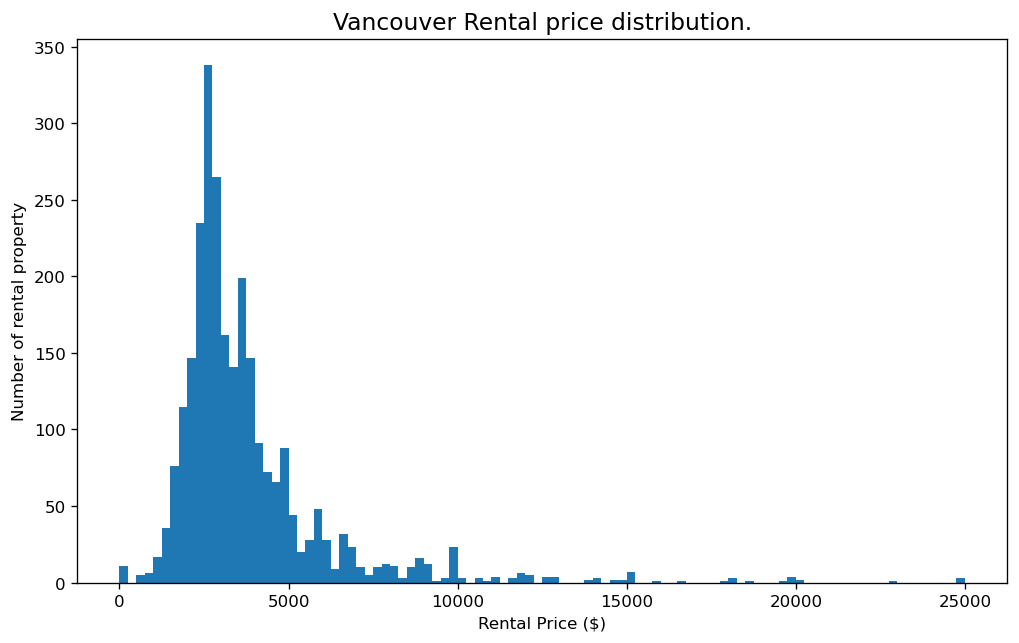

In [45]:
plt.hist(df["Price"], bins=100)
plt.title(f'{city} Rental price distribution.', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

## Relationship between Price and SQFT

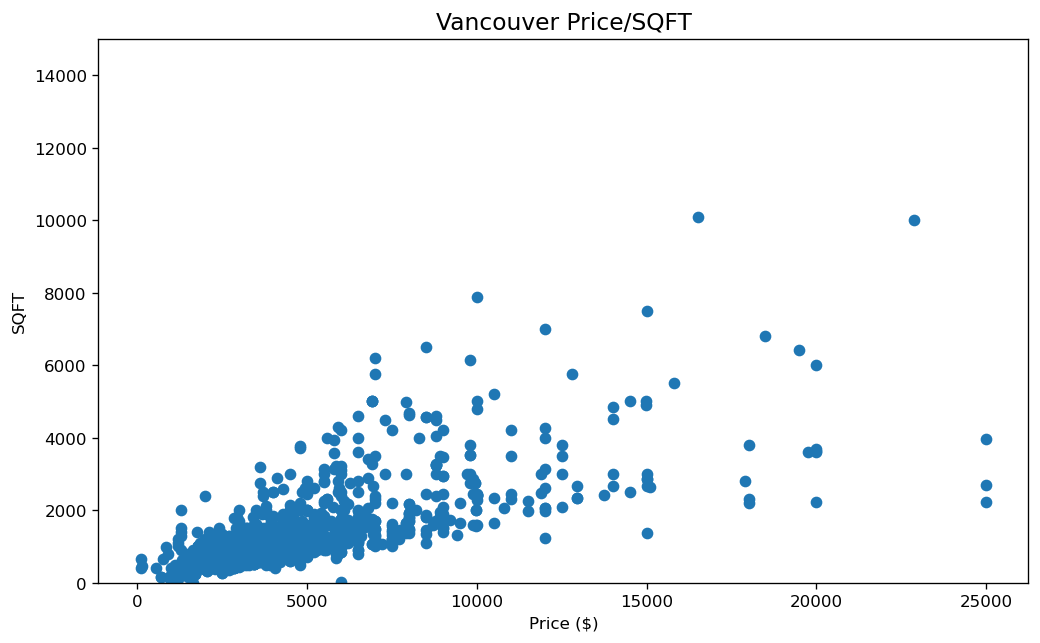

In [46]:
# Relationship between SQFT and Price
plt.scatter(x=df["Price"], y=df["SQFT"])
plt.ylim((0, 15000))
plt.title(f"{city} Price/SQFT", fontsize=14)
plt.xlabel(f"Price ($)")
plt.ylabel(f"SQFT");

Get the per SQFT price. 

In [47]:
df["Price/SQFT"] = df["Price"] / df["SQFT"]
p_per_sqft_df = df[["Neighborhood", "Bedroom", "Price", "Price/SQFT"]].sort_values(by="Price/SQFT", ascending=False)

In [48]:
# Drop rows if sqft is zero
p_per_sqft_df.fillna(0, inplace=True)
no_sqft_idx = p_per_sqft_df[p_per_sqft_df["Price/SQFT"] == 0].index
p_per_sqft_df.drop(no_sqft_idx, axis=0, inplace=True)

In [49]:
# Drop rows if Price/SQFT > $20
p_per_sqft_df = p_per_sqft_df[p_per_sqft_df["Price/SQFT"] < 20]

## Distribution of Per SQFT Price

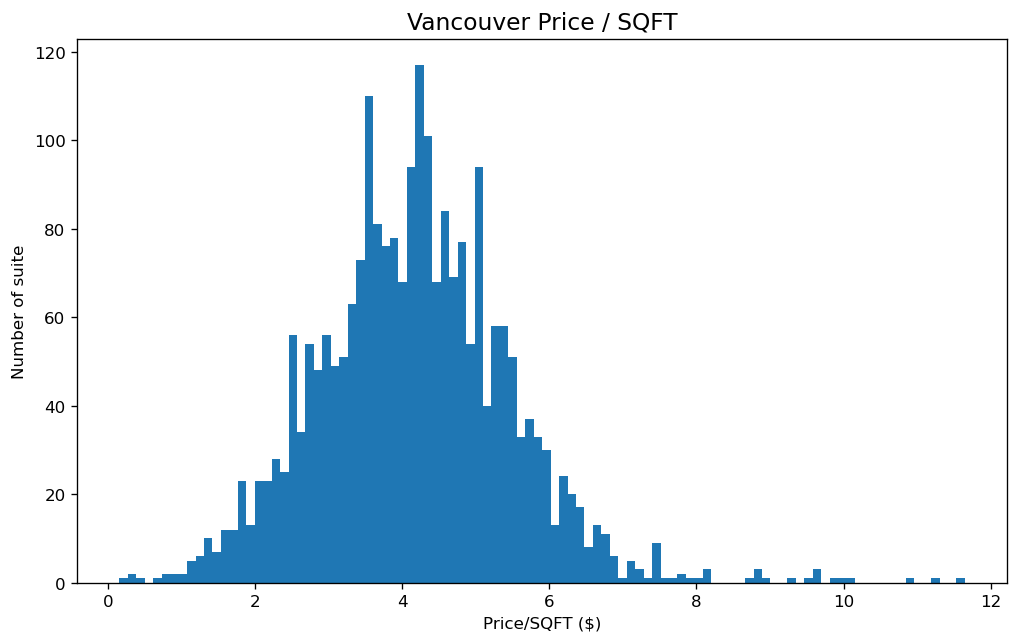

In [50]:
plt.hist(p_per_sqft_df["Price/SQFT"], bins=100)
plt.title(f"{city} Price / SQFT", fontsize=14)
plt.xlabel("Price/SQFT ($)")
plt.ylabel("Number of suite");

In [20]:
# Average, Min, Max Price/SQFT in each area
p_per_sqft_df["Neighborhood"].value_counts().head(15)

vancouver                            659
city of vancouver                    143
downtown vancouver                   134
yaletown                              90
1022 nelson street, vancouver, bc     82
kitsilano                             59
downtown                              52
west end                              45
coal harbour                          38
mount pleasant                        26
burnaby                               21
olympic village                       19
ubc                                   14
south vancouver                       13
marpole                               12
Name: Neighborhood, dtype: int64

In [51]:
# Drop all of the neighborhood is 1. 
p_per_neighbor = p_per_sqft_df.groupby(by="Neighborhood").agg({"Price/SQFT": ['count', 'mean', 'min', 'max']})
p_per_neighbor['Price/SQFT'].sort_values(by='count', ascending=False).head(15)

,count,mean,min,max
Neighborhood,,,,
vancouver,1263,4.008244,0.153846,11.650485
downtown,280,4.967458,1.962500,10.877447
yaletown,148,4.903523,1.842308,8.996851
kitsilano,59,3.927921,1.090909,6.211111
west end,49,4.931328,3.016453,7.096531
coal harbour,38,4.360072,2.765152,6.925743
mount pleasant,26,4.368562,2.227273,5.743405
burnaby,21,3.432951,2.093023,4.672897
olympic village,19,4.552712,3.044456,5.849057


## Number of ads on each bedroom

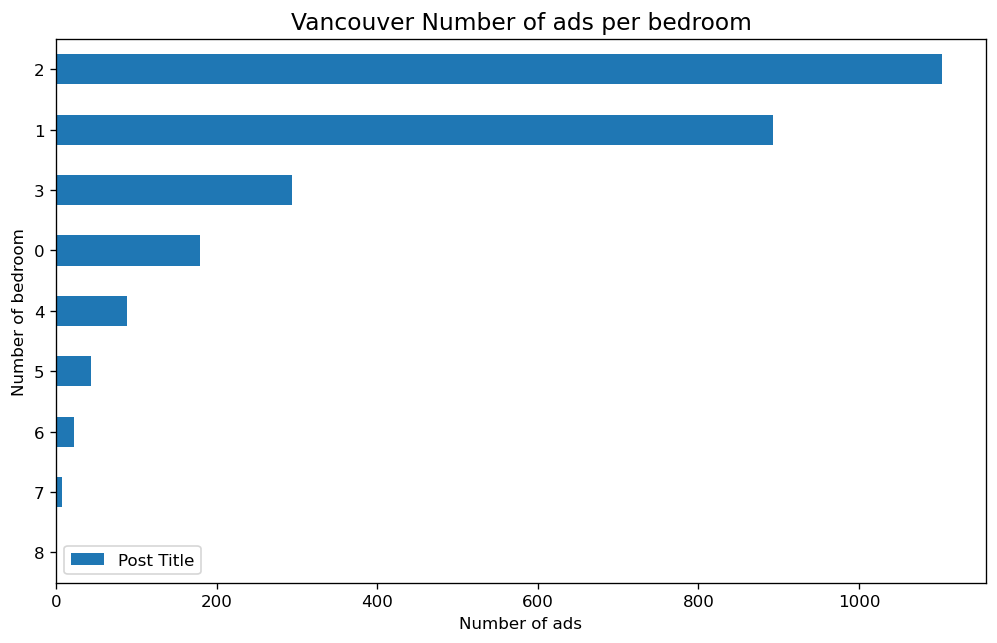

In [52]:
num_bed = df.groupby('Bedroom').agg({'Post Title': 'count'}).sort_values(by='Post Title', ascending=True)
num_bed.plot(kind='barh')
plt.title(f"{city} Number of ads per bedroom", fontsize=14)
plt.xlabel("Number of ads")
plt.ylabel("Number of bedroom");

In [23]:
# Percentage of the number of listing. 
num_bed["percent"] = num_bed / len(df) * 100
num_bed.rename(columns={'Post Title': "Number of Ads", 'percent': 'Percentage'}, inplace=True)

In [24]:
num_bed

,Number of Ads,Percentage
Bedroom,,
8,1,0.037994
7,7,0.265957
6,21,0.797872
5,44,1.671733
4,87,3.305471
0,174,6.610942
3,295,11.208207
1,897,34.080547
2,1106,42.021277


In [25]:
# Price less than $300
df[df['Price'] < 300]

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
435,VANVAN,2022-12-19 08:23:00,2022-12-19,08:23:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/del...,1644 nelson st.,0,NaN,0,False,NaN
980,VANVAN,2022-12-17 15:59:00,2022-12-17,15:59:00,Need help with housing,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,0,NaN,1,False,NaN
1133,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,riley park,1,NaN,140,False,NaN
1801,VANVAN,2022-12-13 11:30:00,2022-12-13,11:30:00,DO NOT LIVE HERE - 124 DUNLEVY AVE,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,0,NaN,0,False,NaN
1955,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,400.0,120,True,0.300000
2338,VANVAN,2022-12-08 14:02:00,2022-12-08,14:02:00,DO NOT RENT 1310 WEST 10TH AVE,https://vancouver.craigslist.org/van/apa/d/van...,fairview,1,NaN,0,False,NaN
2497,VANVAN,2022-12-06 21:27:00,2022-12-06,21:27:00,Sublet available Vancouver Dec 19th to Jan 2nd,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,90,False,NaN
2587,VANVAN,2022-12-06 01:57:00,2022-12-06,01:57:00,No Cooking is Illegal,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,1,NaN,0,False,NaN
2776,VANVAN,2022-12-04 15:12:00,2022-12-04,15:12:00,DT One Bedroom One Bath Furnished Dec 21-29 2022,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,650.0,100,True,0.153846
2982,VANVAN,2022-11-30 20:47:00,2022-11-30,20:47:00,1 Bedroom suite furnished,https://vancouver.craigslist.org/van/apa/d/van...,vancouver east,1,450.0,150,True,0.333333


This post is daily rental. From this, I assume teh rental price around $100 would be daily rental suite. 

What about $1 or $0 posts?

In [27]:
# $1 ads
one_dollar = df[df["Price"] == 1]
one_dollar["Post URL"]

980    https://vancouver.craigslist.org/van/apa/d/van...
Name: Post URL, dtype: object

In [28]:
# $0 ads
zero_dollar = df[df["Price"] == 0]
zero_dollar

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
435,VANVAN,2022-12-19 08:23:00,2022-12-19,08:23:00,Westsea Place - (Westend) - Studio & 1 Bedroom...,https://vancouver.craigslist.org/van/apa/d/del...,1644 nelson st.,0,NaN,0,False,NaN
1801,VANVAN,2022-12-13 11:30:00,2022-12-13,11:30:00,DO NOT LIVE HERE - 124 DUNLEVY AVE,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,0,NaN,0,False,NaN
2338,VANVAN,2022-12-08 14:02:00,2022-12-08,14:02:00,DO NOT RENT 1310 WEST 10TH AVE,https://vancouver.craigslist.org/van/apa/d/van...,fairview,1,NaN,0,False,NaN
2587,VANVAN,2022-12-06 01:57:00,2022-12-06,01:57:00,No Cooking is Illegal,https://vancouver.craigslist.org/van/apa/d/van...,city of vancouver,1,NaN,0,False,NaN


I think it most likely 0 dollar and 1 dollar ads are just not showing the price, so I will drop those rows from DataFrame. 

In [29]:
# Drop low-end outliers rows
drop_index = []
for idx in one_dollar.index:
    drop_index.append(idx)
for idx in zero_dollar.index:
    drop_index.append(idx)
print(f"Original DataFrame Size:{len(df)}\nNumber of Dropped Rows: {len(drop_index)}")
df.drop(drop_index,axis=0, inplace=True)
print(f"DataFrame size after drop rows: {len(df)}")

Original DataFrame Size:2632
Number of Dropped Rows: 5
DataFrame size after drop rows: 2627


## Analyze - 1

From the Histgram, the highest amount of rental is between 1000 to 5000. First I look what kind of market above 5000. 

I call this as 

## High-End market research


In [30]:
# top 100 higest price 
top_100_price = df[['Post Datetime', 'Neighborhood', 'Bedroom', 'SQFT', 'Price', 'IsFurnished']].sort_values(
                by="Price", ascending=False).head(100)
top_100_price


,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
1977,2022-12-12 10:56:00,vancouver,4,3958.0,25000,False
1560,2022-12-14 16:51:00,vancouver,2,2694.0,25000,True
854,2022-12-18 09:16:00,vancouver,3,2223.0,24995,True
199,2022-12-19 12:19:00,west vancouver,6,10000.0,22880,True
1828,2022-12-13 08:57:00,vancouver,3,3636.0,20000,False
...,...,...,...,...,...,...
1186,2022-12-16 16:51:00,city of vancouver,2,1722.0,9200,False
2906,2022-12-01 21:57:00,kitsilano,4,3477.0,9000,False
424,2022-12-19 08:46:00,vancouver,3,1400.0,9000,False
212,2022-12-19 12:09:00,yaletown downtown vancouver,2,2936.0,9000,False


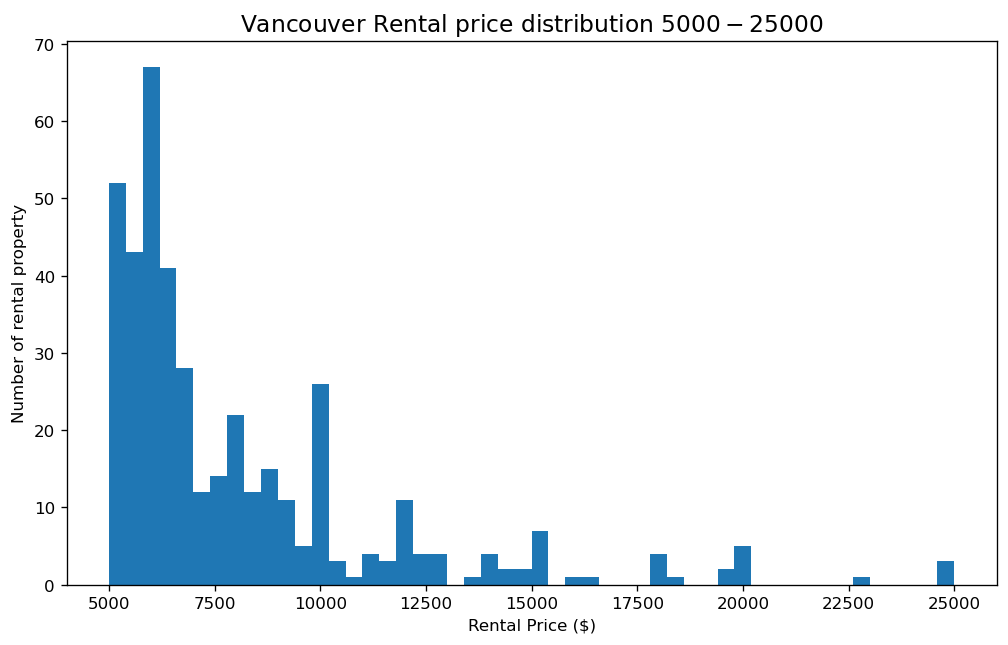

In [31]:
# What about distribution $5000 and up?
price_range = (5000, df["Price"].max())
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [32]:
# Get URL on 2 Bedroom suite in top 100. 
highest_two_bed = top_100_price[top_100_price['Bedroom'] == 2]
highest_two_bed_idx = highest_two_bed.index
for idx in highest_two_bed_idx:
    print(f'Index Number - {idx} : {df.loc[idx]["Post URL"]}')


Index Number - 1560 : https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7560020204.html
Index Number - 2407 : https://vancouver.craigslist.org/van/apa/d/vancouver-vancouver-downtown-fairmont/7554964282.html
Index Number - 2907 : https://vancouver.craigslist.org/van/apa/d/rare-harbour-green-one-ft-stunning/7563703745.html
Index Number - 1424 : https://vancouver.craigslist.org/van/apa/d/vancouver-uniqueaccommodationscom/7567894912.html
Index Number - 163 : https://vancouver.craigslist.org/van/apa/d/vancouver-three-harbour-green-2brden-at/7568800034.html
Index Number - 2570 : https://vancouver.craigslist.org/van/apa/d/vancouver-super-luxury-07-fairmont-bed/7565383014.html
Index Number - 192 : https://vancouver.craigslist.org/van/apa/d/vancouver-luxurious-private-estates-of/7568768831.html
Index Number - 203 : https://vancouver.craigslist.org/van/apa/d/vancouver-luxur-bed-half-bath-furnished/7568583680.html
Index Number - 782 : https://vancouver.craigslist.org/

#### What is 0.85% RULE?

This is the rough calculation to find out the purchase price to give 5 - 8% cash flow from your rental revenue with today's motgagerate. It's not accurate number but great place to start evaluating the home price for your investment. 

In [33]:
# Average Price on those pent house
avg_rent = np.average(highest_two_bed["Price"][1:].to_numpy())
max_rent = np.max(highest_two_bed["Price"][1:].to_numpy())
# 0.85% RULE
avg_house_p = np.round(avg_rent / (0.85/100), 2)
max_house_p = np.round(max_rent / (0.85/100), 2)
print(f"Price between ${avg_house_p*0.8} - ${max_house_p}")

Price between $1101176.472 - $2117647.06


In [34]:
# Rental price higher than $5000.
more_than_5000 = df[df["Price"] > 5000]
more_than_5000.groupby(by=["Bedroom", "IsFurnished"]).agg({'SQFT': ["min", "max"],
                                                         "Price": ['min', 'max', 'count']})

SQFT           Price             
                        min      max    min    max count
Bedroom IsFurnished                                     
0       True         1357.0   1357.0   8000   8000     1
1       False        2000.0   2000.0   6500   6500     1
        True          900.0   1855.0   5500  10000     3
2       False         675.0   2936.0   5190  18000    90
        True          800.0   2873.0   5100  25000    68
3       False          14.0   4000.0   5100  20000    79
        True         1050.0   4000.0   5200  24995    31
4       False         900.0   4600.0   5200  25000    37
        True         2000.0   6800.0   5500  18500    16
5       False        1500.0   6426.0   5200  19500    27
        True         2250.0   6500.0   6088  14995     9
6       False        2300.0  10098.0   5600  16500    13
        True         4639.0  29789.0   5600  22880     6
7       False        2900.0   4800.0   6800   9995     5
        True         6000.0   6000.0  19995  19995     1
8       False        4980.0   4980.0   7900   7900     1

In [35]:
# top 10 most expensive rental in Vancouver
top_10 = top_100_price.head(10)
top_10

,Post Datetime,Neighborhood,Bedroom,SQFT,Price,IsFurnished
1977,2022-12-12 10:56:00,vancouver,4,3958.0,25000,False
1560,2022-12-14 16:51:00,vancouver,2,2694.0,25000,True
854,2022-12-18 09:16:00,vancouver,3,2223.0,24995,True
199,2022-12-19 12:19:00,west vancouver,6,10000.0,22880,True
1828,2022-12-13 08:57:00,vancouver,3,3636.0,20000,False
1174,2022-12-16 17:35:00,yaletown,3,2223.0,20000,False
116,2022-12-19 14:21:00,dowtown,4,3700.0,19998,False
808,2022-12-18 09:46:00,west vancouver,7,6000.0,19995,True
402,2022-12-19 09:10:00,west vancouver,3,3600.0,19975,False
118,2022-12-19 14:21:00,lions bay/west vancouver,3,3600.0,19750,False


In [36]:
# Then get the URL on those top 10 most expensive rental in Vancouver. 
top_10_idx = top_10.index
for idx in top_10_idx:
    print(f'Index Number - {idx}/Number of Bedroom - {df.loc[idx]["Bedroom"]}/SQFT - {df.loc[idx]["SQFT"]}/Location - {df.loc[idx]["Neighborhood"]}\n{df.loc[idx]["Post URL"]}')

Index Number - 1977/Number of Bedroom - 4/SQFT - 3958.0/Location - vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-ultra-customized-morden/7567534610.html
Index Number - 1560/Number of Bedroom - 2/SQFT - 2694.0/Location - vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-furnished-two-bedroom-sub/7560020204.html
Index Number - 854/Number of Bedroom - 3/SQFT - 2223.0/Location - vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-luxury-furnished-bed-den-bath/7568077632.html
Index Number - 199/Number of Bedroom - 6/SQFT - 10000.0/Location - west vancouver
https://vancouver.craigslist.org/van/apa/d/west-vancouver-furnished-luxury-mansion/7562366149.html
Index Number - 1828/Number of Bedroom - 3/SQFT - 3636.0/Location - vancouver
https://vancouver.craigslist.org/van/apa/d/vancouver-coal-harbour-luxury-three/7563551392.html
Index Number - 1174/Number of Bedroom - 3/SQFT - 2223.0/Location - yaletown
https://vancouver.craigslist.org/van/apa/d/vancouver-l

From above data, Downtown Vanvouver rental market is different world. I must make decision to define what is the outlier of high-end rental. 

If the number of the high-end prices are large enough, I can make DataFrame for only high-end and search for the high-end market opportunities. 

Clearly, I should not mix with regular market and high-end market because it will provide me biased price average to determin the valuse of the house. 

I am wondering that <a href='https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/Table?TableId=2.1.31.3&GeographyId=2410&GeographyTypeId=3&DisplayAs=Table&GeograghyName=Vancouver'>CMHC Vancouver rental market report</a> concerns about those outliers. 

## Analyze - 2 


## Analyze under 5000, and i call them for regular market. 
* What is the percentage of the Furnished rental suite? 
* Is there any price different? 
* How many bedroom suite has most on ads? And is it any different in area?
* How much is the rental price in general? 


Tne price around $100 is most likely daily rental so I will store in different variable so I might be able to do something with them. 

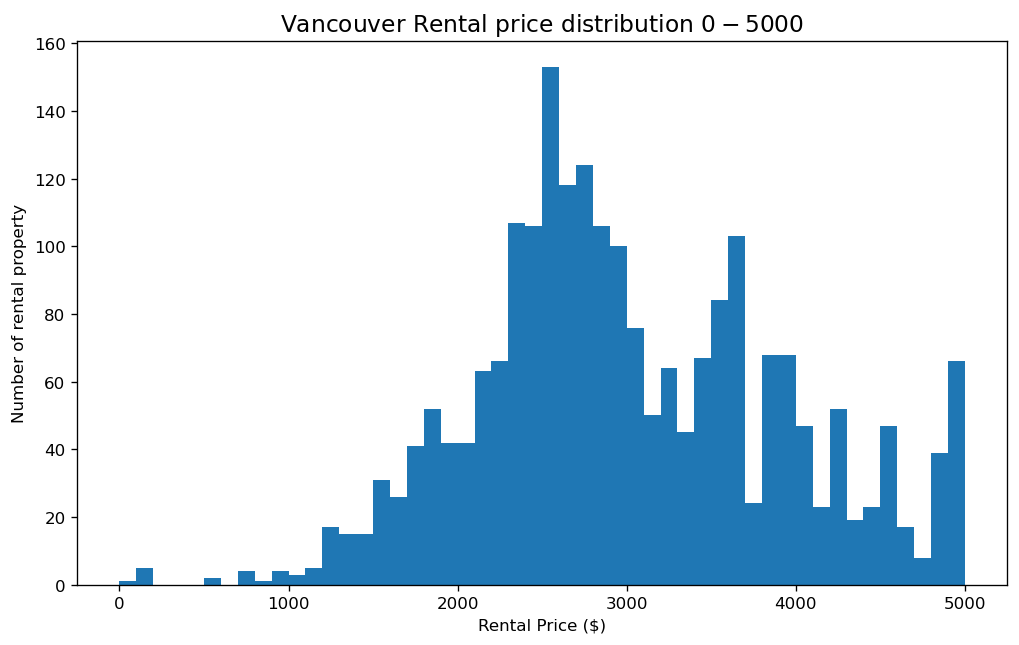

In [37]:
# What about distribution $0 - $5000?
price_range = (0, 5000)
plt.hist(df["Price"], bins=50, range=price_range)
plt.title(f'{city} Rental price distribution ${price_range[0]} - ${price_range[1]}', fontsize=14)
plt.xlabel("Rental Price ($)")
plt.ylabel("Number of rental property");

In [38]:
day_rental = df[df["Price"].between(10, 300)]
day_rental

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
1133,VANVAN,2022-12-16 18:53:00,2022-12-16,18:53:00,New basement suite in Riley Park Neighbourhood,https://vancouver.craigslist.org/van/apa/d/van...,riley park,1,NaN,140,False,NaN
1955,VANVAN,2022-12-12 13:20:00,2022-12-12,13:20:00,Vancouver Furnished Master Bedroom for Rent,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,400.0,120,True,0.300000
2497,VANVAN,2022-12-06 21:27:00,2022-12-06,21:27:00,Sublet available Vancouver Dec 19th to Jan 2nd,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,90,False,NaN
2776,VANVAN,2022-12-04 15:12:00,2022-12-04,15:12:00,DT One Bedroom One Bath Furnished Dec 21-29 2022,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,650.0,100,True,0.153846
2982,VANVAN,2022-11-30 20:47:00,2022-11-30,20:47:00,1 Bedroom suite furnished,https://vancouver.craigslist.org/van/apa/d/van...,vancouver east,1,450.0,150,True,0.333333
3032,VANVAN,2022-11-29 22:17:00,2022-11-29,22:17:00,Bright Apartment to rent,https://vancouver.craigslist.org/van/apa/d/van...,kitsilano,1,NaN,100,False,NaN


In [39]:
# Drop the rental price over $5000. 
under_5000 = df.drop(more_than_5000.index, axis=0)
print(f'Drop {len(more_than_5000)} rows and data contains {len(under_5000)} rows of data.')

Drop 388 rows and data contains 2239 rows of data.


In [40]:
# then also drop daily rentals
under_5000 = under_5000.drop(day_rental.index, axis=0)
print(f'Drop {len(day_rental)} rows and data contains {len(under_5000)} rows of data.')

Drop 6 rows and data contains 2233 rows of data.


In [41]:
# What is the top 10 highest price on under $5000. Is it no outlier?
under_5000.sort_values(by="Price", ascending=False).head(10)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
152,VANVAN,2022-12-19 13:15:00,2022-12-19,13:15:00,$5000 / 3br - 1275ft2 - A/C 3Bed2B1Den on the ...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver downtown coal habour,3,1275.0,5000,False,3.921569
2636,VANVAN,2022-12-05 20:03:00,2022-12-05,20:03:00,3 Bedroom + Den Sub-Penthouse at 8X On the Par...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,3,1200.0,5000,False,4.166667
1931,VANVAN,2022-12-12 16:27:00,2022-12-12,16:27:00,UBC furnished ocean view 2 bedroom for rent,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,NaN,5000,True,NaN
1962,VANVAN,2022-12-12 12:24:00,2022-12-12,12:24:00,Yaletown fully furnished 3 bedroom sub-penthou...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,3,1980.0,5000,True,2.525253
1381,VANVAN,2022-12-15 16:21:00,2022-12-15,16:21:00,2 BED + DEN W/ VIEWS FOR RENT @ CIELO!!,https://vancouver.craigslist.org/van/apa/d/van...,coal harbour,2,1277.0,5000,False,3.915427
3040,VANVAN,2022-11-29 18:54:00,2022-11-29,18:54:00,Rare Fully Renovated Luxury Spacious 3 Bedroom...,https://vancouver.craigslist.org/van/apa/d/van...,yaletown,3,1600.0,5000,False,3.125000
2026,VANVAN,2022-12-11 21:20:00,2022-12-11,21:20:00,NEW BUILDING-Available February 1st -Pet Frien...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,3,745.0,5000,False,6.711409
2027,VANVAN,2022-12-11 21:18:00,2022-12-11,21:18:00,Available February 1st - NEW BUILDING Pet Frie...,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,3,745.0,5000,False,6.711409
3033,VANVAN,2022-11-29 21:45:00,2022-11-29,21:45:00,(UniqueAccommodations.com) ID:5251 Furnished 2...,https://vancouver.craigslist.org/van/apa/d/van...,"kitsilano, vancouver",2,1280.0,5000,True,3.906250
127,VANVAN,2022-12-19 14:14:00,2022-12-19,14:14:00,"--(OBsold.com)-- Stunning Furnished 1bd+den, m...",https://vancouver.craigslist.org/van/apa/d/nor...,lower lonsdale,1,733.0,5000,True,6.821282


In [42]:
# How many rentals are $5000?
under_5000[under_5000["Price"] == 5000] 

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
11,VANVAN,2022-12-19 17:51:00,2022-12-19,17:51:00,(ORCA_REF#1101-1000)2 bdrm 2 bath apt,https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,2,1350.0,5000,False,3.703704
127,VANVAN,2022-12-19 14:14:00,2022-12-19,14:14:00,"--(OBsold.com)-- Stunning Furnished 1bd+den, m...",https://vancouver.craigslist.org/van/apa/d/nor...,lower lonsdale,1,733.0,5000,True,6.821282
151,VANVAN,2022-12-19 13:15:00,2022-12-19,13:15:00,5 star luxury Shangri-La hotel condo(furnished...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1045.0,5000,False,4.784689
152,VANVAN,2022-12-19 13:15:00,2022-12-19,13:15:00,$5000 / 3br - 1275ft2 - A/C 3Bed2B1Den on the ...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver downtown coal habour,3,1275.0,5000,False,3.921569
317,VANVAN,2022-12-19 10:10:00,2022-12-19,10:10:00,2 Bed 2 Bath + Den/Solarium Furnished with Par...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,2,1000.0,5000,True,5.000000
552,VANVAN,2022-12-18 22:43:00,2022-12-18,22:43:00,FRASER AND 41ST VANCOUVER EAST HOUSE 3 BED 2 BATH,https://vancouver.craigslist.org/van/apa/d/van...,"905 e 41st ave, vancouver v5w 1p8",3,2000.0,5000,False,2.500000
556,VANVAN,2022-12-18 22:40:00,2022-12-18,22:40:00,"Fully Furnished 2bdrm, 2 bath condo for 1 month",https://vancouver.craigslist.org/van/apa/d/van...,downtown vancouver,2,800.0,5000,True,6.250000
677,VANVAN,2022-12-18 16:28:00,2022-12-18,16:28:00,Luxury modern new furnished Vancouver Suite,https://vancouver.craigslist.org/van/apa/d/van...,"vancouver, mount pleasant heart of vancouver",2,950.0,5000,True,5.263158
1168,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Furnished Short term Apartment at Avenue O...,https://vancouver.craigslist.org/van/apa/d/van...,olympic village,2,1000.0,5000,True,5.000000
1157,VANVAN,2022-12-16 17:36:00,2022-12-16,17:36:00,A/C Pet friendly Apartment at Cambie Gardens 7...,https://vancouver.craigslist.org/van/apa/d/van...,oakridge,2,1155.0,5000,False,4.329004


In [43]:
# What is the cheapest rent?
under_5000.sort_values(by="Price").head(20)

,PostAreaCode,Post Datetime,Post Date,Post Time,Post Title,Post URL,Neighborhood,Bedroom,SQFT,Price,IsFurnished,Price/SQFT
2020,VANVAN,2022-12-11 21:39:00,2022-12-11,21:39:00,Double Car Garage for rent !!,https://vancouver.craigslist.org/van/apa/d/van...,vancouver east fraserview area,0,400.0,550,False,1.375000
730,VANVAN,2022-12-18 12:44:00,2022-12-18,12:44:00,Rooms in SRO building from $595,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,NaN,595,False,NaN
766,VANVAN,2022-12-18 11:07:00,2022-12-18,11:07:00,Nice and cozy room available (H65) (Surrey),https://vancouver.craigslist.org/van/apa/d/sur...,surrey,1,NaN,700,False,NaN
1121,VANVAN,2022-12-16 19:59:00,2022-12-16,19:59:00,Unique Basement Suite with High Ceiling,https://vancouver.craigslist.org/van/apa/d/van...,east first ave vancouver bc,1,150.0,700,False,4.666667
1300,VANVAN,2022-12-16 09:08:00,2022-12-16,09:08:00,Microsuite Available Now,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,150.0,700,False,4.666667
2851,VANVAN,2022-12-03 08:11:00,2022-12-03,08:11:00,1 bedroom available for rent in a shared suite,https://vancouver.craigslist.org/van/apa/d/van...,21st east avenue and maxwell,1,650.0,750,False,1.153846
2489,VANVAN,2022-12-06 23:42:00,2022-12-06,23:42:00,Room for rent $830/month! utilities & internet...,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,997.0,830,False,0.832497
1260,VANVAN,2022-12-16 11:50:00,2022-12-16,11:50:00,student accommodation,https://vancouver.craigslist.org/van/apa/d/van...,vancouver,1,800.0,900,False,1.125000
2295,VANVAN,2022-12-08 20:02:00,2022-12-08,20:02:00,Micro-Mini suite(Ground Level 5th and Nanaimo/...,https://vancouver.craigslist.org/van/apa/d/mic...,vancouver east,0,191.0,950,False,4.973822
956,VANVAN,2022-12-17 18:44:00,2022-12-17,18:44:00,One in Kits on West Broadway 10 mins from UBC...,https://vancouver.craigslist.org/van/apa/d/van...,"kitsilano, vancouver",6,NaN,950,False,NaN


In [44]:
# Count how many rentals are furnished 
num_furnished_suite = df[df['IsFurnished'] == True]["IsFurnished"].count()
num_unfurnished_suite = len(df) - num_furnished_suite
furnished_suite_percent = np.round((num_furnished_suite / len(df)) * 100, 2)
print(f"Number of furnished suite is {num_furnished_suite}, and it's {furnished_suite_percent}% of the entire list.")

Number of furnished suite is 637, and it's 24.25% of the entire list.


In [45]:
# Find out the number of ads on each bedrooms number.  
num_bed = np.sort(df["Bedroom"].unique())
suite_counts = []
for i in range(len(num_bed)):
    suite_count = len(df[df['Bedroom'] == num_bed[i]])
    suite_counts.append(suite_count)
    #print(f'Number of {num_bed[i]} Bedroom suite: {len(df[df["Bedroom"] == num_bed[i]])}')
#print(f"List of suite counts: {suite_counts}")

In [46]:
# Find out Mean, Max, Min of SQFT and Price of each bedroom and SUM of furnished suite and total suite on each bedroom. 
df_count = df.groupby(by=['Bedroom']).agg({'SQFT': ['mean', 'max', 'min'],
                                                 'Price': ['mean', 'max', 'min'],
                                                  'IsFurnished': ['sum', 'count']})
df_count['percent furnished'] = df_count['IsFurnished']['sum'] / df_count["IsFurnished"]['count']
df_count

SQFT                         Price              IsFurnished  \
                mean      max     min         mean    max   min         sum   
Bedroom                                                                       
0         434.697987   1357.0   103.0  2292.204678   8000   550          50   
1         616.625964   2400.0     1.0  2549.391061  10000    90         253   
2         987.048611   2936.0   500.0  3930.555154  25000  1175         248   
3        1565.863469   4000.0    14.0  5527.498305  24995  1000          52   
4        2633.594937   6800.0   900.0  6997.045977  25000  3000          18   
5        3700.390244   6500.0  1500.0  8437.545455  19500  1300           9   
6        6603.105263  29789.0  2300.0  9376.428571  22880   950           6   
7        4028.333333   6000.0  1300.0  9084.285714  19995  1300           1   
8        4980.000000   4980.0  4980.0  7900.000000   7900  7900           0   

              percent furnished  
        count                    
Bedroom                          
0         171          0.292398  
1         895          0.282682  
2        1106          0.224231  
3         295          0.176271  
4          87          0.206897  
5          44          0.204545  
6          21          0.285714  
7           7          0.142857  
8           1          0.000000

In [47]:
# Price per furnished suit on each bedroom
#df_price_furnished = df.drop(['Post Datetime', 'Post Title', 'Post URL', 'Neighborhood'], axis=1)
df_price_furnished = df.groupby(['Bedroom', 'IsFurnished']).agg({'Price': ['mean', 'max', 'min', 'count'],
                                                               "SQFT": ['mean', 'max', 'min']})
df_price_furnished

Price                              SQFT           \
                             mean    max    min count          mean      max   
Bedroom IsFurnished                                                            
0       False         2217.371901   4050    550   121    432.028302   1200.0   
        True          2473.300000   8000   1450    50    441.279070   1357.0   
1       False         2405.823988   6500     90   642    620.468007   2400.0   
        True          2913.699605  10000    100   253    607.528139   1855.0   
2       False         3706.013986  18000   1190   858    971.061935   2936.0   
        True          4707.395161  25000   1175   248   1040.223176   2873.0   
3       False         5149.987654  20000   1000   243   1538.031818   4000.0   
        True          7291.634615  24995   2500    52   1685.921569   4000.0   
4       False         6407.362319  25000   3000    69   2574.935484   4600.0   
        True          9257.500000  18500   4800    18   2847.529412   6800.0   
5       False         8187.971429  19500   1300    35   3706.062500   6426.0   
        True          9408.111111  14995   6088     9   3680.222222   6500.0   
6       False         8228.333333  16500    950    15   4880.785714  10098.0   
        True         12246.666667  22880   5600     6  11425.600000  29789.0   
7       False         7265.833333   9995   1300     6   3634.000000   4800.0   
        True         19995.000000  19995  19995     1   6000.000000   6000.0   
8       False         7900.000000   7900   7900     1   4980.000000   4980.0   

                             
                        min  
Bedroom IsFurnished          
0       False         103.0  
        True          180.0  
1       False           1.0  
        True          361.0  
2       False         500.0  
        True          500.0  
3       False          14.0  
        True          781.0  
4       False         900.0  
        True         1450.0  
5       False        1500.0  
        True         2250.0  
6       False        2300.0  
        True         4639.0  
7       False        1300.0  
        True         6000.0  
8       False        4980.0

Dropped extrimely low price add, and it seems no outlier on the price

In [48]:
# Count how many ads per day.1=Mon, 2=Tue, ......, 7=Sun
df["Weekday"] = df["Post Datetime"].dt.isocalendar().day
num_ad_per_day_df = df.groupby('Post Date').agg({'Post Title': 'count',
                                                "Weekday": 'first'})

num_ad_per_day_df

,Post Title,Weekday
Post Date,,
2022-11-29,29,2
2022-11-30,44,3
2022-12-01,60,4
2022-12-02,44,5
2022-12-03,40,6
2022-12-04,54,7
2022-12-05,115,1
2022-12-06,80,2
2022-12-07,101,3


Which day of the week have more ads? 

Is there any day of the week that having more ads than others? 

## Share

#### Data Visualization:
The most important thing is what information do I want to tell. 

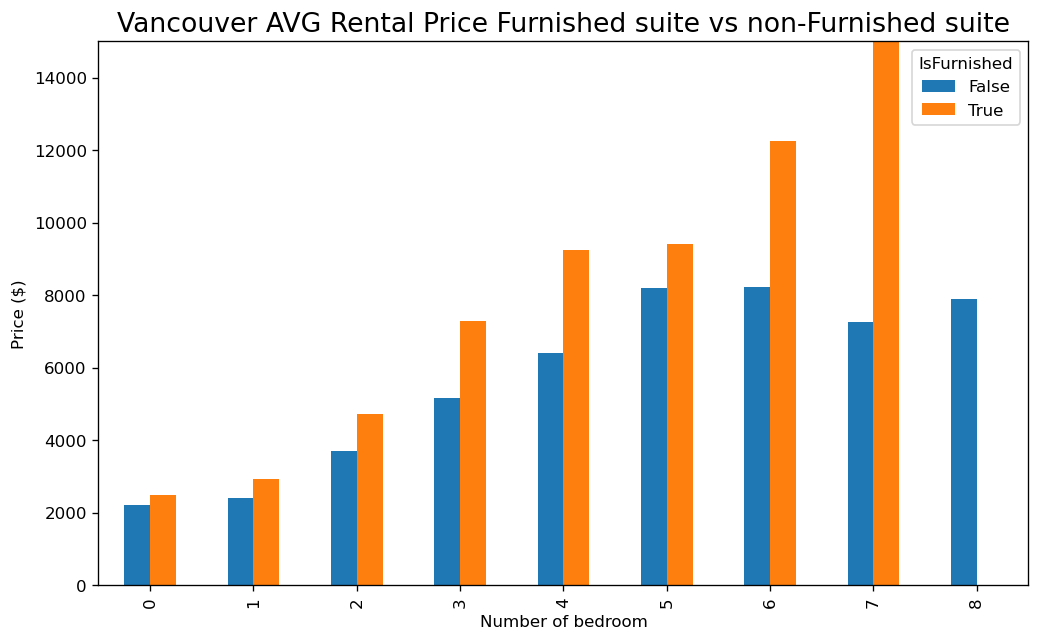

In [49]:
df_price_furnished["Price"]["mean"].unstack().plot(kind='bar')
plt.title(f'{city} AVG Rental Price Furnished suite vs non-Furnished suite', fontsize=16)
plt.xlabel('Number of bedroom')
plt.ylabel('Price ($)')
plt.ylim((0, 15000));

## Act